# DATA620 Final Project A
## Network Analysis

# Project Description
***

We would like to find businesses (or ideally people) who are influential in drawing foreign and domestic investment in Myanmar.  Through basic network analysis techniques, we hope to find a clique of people or companies with common investment sources or common activities.

# Data Description
***

This data was scraped and realeased anonymously from official government sources in two leaks called Myanmar Financials and Myanmar Investments.  The former is incorporation documents for ~125k companies, and the latter is information from investment proposals for about 10k companies.

# Known Challenges
***

1. About 1/4 of the companies in Myanmar Financials paid somebody to approve their incorporation documents without addresses or names... We can remove companies with no listed officers.

2. People in Myanmar are named for astrological information pertaining to their birth.  There is no family name, and many people have the same names.  We also cannot do anything about this.

3. A small number of names are given in Burmese script, which is included in UTF-8, but is unreadable to our team.  We can leave the script as-is, and remove punctuation.

4. Most companies did not apply for investment approval.  We will focus only on companies with investment records.

# Method
***

1. Import and clean the data
2. Create an edge list:
> |Company Name |People
> --- | --- 
> |companyNameInMyanmar |officers, landOwner, nameOfInvestor
3. Project bipartite graph, view statistics
4. Trim edges, weighted by number of names per company
5. Visualize

In [1]:
import os
import scipy
from pathlib import *
import json
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import string
from collections import defaultdict
from itertools import combinations

In [2]:
# Company incorporation documents
com_dir = Path('/home/s/fpa/data/company_info')
# Investment proposals and information about real projects
inv_dir = Path('/home/s/fpa/data/investment_info')

# Helper Functions
***
#### pathToList()
- Takes a Path object for a directory full of JSON files
- Returns a list containing a dict for each file read in

#### companyInfo()
- Takes a list of dicts
- Extracts copmany name and names of officers
- Returns a DataFrame with this information

#### investmentInfo()
- Takes a list of lists of dicts
- Converts dicts to DataFrames
- Returns list of DataFrames

#### cleanDF()
- Takes a DataFrame
- Converts all letters to lowercase
- Substitutes ltd with limited
- Removes all punctuation

#### defineEdges()
- Takes company information and a list of other DataFrames
- Creates dictionary with key company name and value list of people
- Adds investors to edge list
- Returns edge list dictionary

#### expandEdges()
- Takes a dictionary of company nodes with lists of connected people
- Returns a list of edges with only two nodes on each line

#### trimEdges()

#### islandMethod()

In [3]:
def pathToList(path_obj):
    file_list = []
    for file_path in path_obj.iterdir():
        data = json.loads(file_path.read_bytes())
        file_list.append(data)
    return(file_list)

def companyInfo(com_list):
    info_list = []
    # Iterate over all companies in the list
    for i in range(len(com_list)):
        info = {}
        # Extract Company Name to "companyNameInMyanmar"
        info['companyNameInMyanmar'] = com_list[i]['Corp']['CompanyName']
        # Extract Officer names
        for b in range(len(com_list[i]['Officers'])):
            info['officer' + str(b)] = com_list[i]['Officers'][b]['FullNameNormalized']
        # Convert to DataFrame
        info_list.append(info)
    df = pd.DataFrame.from_dict(info_list, orient = 'columns')
    return(df)

def investmentInfo(inv_list):
    investments = []
    # Extract data from investment documents
    for i in range(len(inv_list)):
        d = pd.DataFrame.from_dict(
            [x for x in inv_list[i]['data']], orient = 'columns')
        investments.append(d)
    return(investments)

def cleanDF(df):
    # Convert to lowercase
    df = df.applymap(str)
    df = df.applymap(lambda s:s.lower())
    # Remove some useless words
    useless = set(('ltd', 'limited', 'company',))
    for word in useless:
        df = df.applymap(lambda s:s.replace(word, ''))
    # Remove punctuation
    df = df.applymap(lambda s:s.translate(str.maketrans('', '', string.punctuation)))         
    # Remove companies with extremely short names
    df = df[df.companyNameInMyanmar != 'a']
    return(df)

def defineEdges(companies, investments):
    edges = {}
    # add all companies to edge list
    for i in range(len(companies)):
        co = companies.iloc[i,0]
        edges[co] = []

        # add officers as connections
        for j in range(1,68):
            officer = companies.iloc[i,j]
            if officer != 'nan':
                edges[co].append(officer)
            else:
                break
    for doc in investments:
        doc = cleanDF(doc)
        for i in range(len(doc)):
            co = doc.iloc[i]['companyNameInMyanmar']
            inv = doc.iloc[i]['nameOfInvestor']
            # add remaining companies to edge list
            if co not in edges.keys():
                edges[co] = []
            # add investors as connections
            if inv not in edges[co]:
                edges[co].append(str(inv).replace(' ', ''))
    return(edges)

def expandEdges(edges):
    expanded_edges = []
    for company in edges:
        for person in company:
            edge = (company, person)
            expanded_edges.append(edge)
    return(expanded_edges)

def trimEdges(G, weight = 1):
    G2 = nx.Graph()
    edata = nx.to_pandas_edgelist(G)
    f = edata['source']
    to = edata['target']
    
    for f, to, edata in G.edges(data = True):
        if edata['weight'] > weight:
            G2.add_edge(f, to)
    return G2

def islandMethod(g, iterations = 20):
    weights = [edata['weight'] for f, to, edata in g.edges(data = True)]
    mn = 1
    mx = iterations
    step = 1
    return([[threshold, trimEdges(g, threshold)]
           for threshold in range(mn, mx, step)])

# Preprocessing
***

In [4]:
companies = cleanDF(companyInfo(pathToList(com_dir)))
# Drop rows with no names
companies = companies[companies.officer0 != 'nan']

In [5]:
investments = investmentInfo(pathToList(inv_dir))
edges = defineEdges(companies, investments)
expanded_edges = expandEdges(edges)

In [6]:
reversed_edges = defaultdict(list)
for key, value in edges.items():
    for item in value:
        reversed_edges[item].append(key)

# Network Analysis
***

In [7]:
G = nx.Graph()

company_nodes = edges.keys()
people_nodes = reversed_edges.keys()

G.add_nodes_from(company_nodes, bipartite = 'Companies')
G.add_nodes_from(people_nodes, bipartite = 'People')
G.add_edges_from(expanded_edges)

G.number_of_nodes()

218065

In [8]:
G.number_of_edges()

1036600

In [9]:
P = bipartite.weighted_projected_graph(G, people_nodes)
P.number_of_edges()

88341

In [10]:
islands_P = islandMethod(P)

for i in islands_P:
    print('Threshold: ' + str(i[0]))
    print('Number of Nodes: ' + str(len(i[1])))
    print('Length of Connected Components')
    display(pd.DataFrame(pd.Series([len(c) for c in sorted(nx.connected_components(i[1]), key=len)]).value_counts().sort_index()).T)
    print()

Threshold: 1
Number of Nodes: 61596
Length of Connected Components


,96,61500
0,1,1



Threshold: 2
Number of Nodes: 27726
Length of Connected Components


,90,27636
0,1,1



Threshold: 3
Number of Nodes: 448
Length of Connected Components


,86,362
0,1,1



Threshold: 4
Number of Nodes: 446
Length of Connected Components


,84,362
0,1,1



Threshold: 5
Number of Nodes: 445
Length of Connected Components


,83,362
0,1,1



Threshold: 6
Number of Nodes: 445
Length of Connected Components


,83,362
0,1,1



Threshold: 7
Number of Nodes: 442
Length of Connected Components


,80,362
0,1,1



Threshold: 8
Number of Nodes: 442
Length of Connected Components


,80,362
0,1,1



Threshold: 9
Number of Nodes: 441
Length of Connected Components


,79,362
0,1,1



Threshold: 10
Number of Nodes: 440
Length of Connected Components


,78,362
0,1,1



Threshold: 11
Number of Nodes: 439
Length of Connected Components


,78,361
0,1,1



Threshold: 12
Number of Nodes: 429
Length of Connected Components


,77,352
0,1,1



Threshold: 13
Number of Nodes: 419
Length of Connected Components


,77,342
0,1,1



Threshold: 14
Number of Nodes: 382
Length of Connected Components


,2,77,303
0,1,1,1



Threshold: 15
Number of Nodes: 325
Length of Connected Components


,2,77,246
0,1,1,1



Threshold: 16
Number of Nodes: 252
Length of Connected Components


,77,175
0,1,1



Threshold: 17
Number of Nodes: 195
Length of Connected Components


,76,119
0,1,1



Threshold: 18
Number of Nodes: 145
Length of Connected Components


,70,75
0,1,1



Threshold: 19
Number of Nodes: 112
Length of Connected Components


,39,73
0,1,1


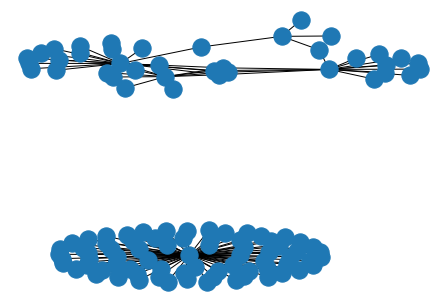

In [11]:
island = islands_P[18][1]
nx.draw(island, with_labels = False)
plt.show()

In [12]:
# Degree, Eigenvector Centrality and Betweenness are weighted by the total
# number of shared contacts.  DEGREE_CENTRALITY and CLOSENESS are not weighted
summaries = pd.DataFrame(dict(
    degree = dict(island.degree(weight = 'weight')),
    degree_centrality = nx.degree_centrality(island),
    eigenvector = nx.eigenvector_centrality_numpy(island, weight = 'weight'),
    closeness = nx.closeness_centrality(island),
    betweenness = nx.betweenness_centrality(island, weight = 'weight')))

summaries = summaries.sort_values(by = 'degree', ascending = False)
summaries[:20]

,degree,degree_centrality,eigenvector,closeness,betweenness
a,72,0.648649,7.071068e-01,0.648649,0.418673
မြန်မာမင်းဒွန်းဂါးမင့်မင်နျူဖက်ချားရင်းကုမ္ပဏီလီမိတက်,22,0.198198,-1.054393e-16,0.197106,0.075221
အရှေ့တိုင်းအထည်ချုပ်ကုမ္ပဏီလီမိတက်,14,0.126126,-8.715114e-16,0.156735,0.053392
ထရိုင်းဒင့်မြန်မာဂျင်နရယ်ထရိတ်ဒင်းကုမ္ပဏီလီမိတက်,11,0.099099,-5.417107e-16,0.162613,0.017654
သိန်းငှက်အပြည်ပြည်ဆိုင်ရာစက်မှုလီမိတက်,4,0.036036,2.053466e-17,0.122727,0.012947
pyi phyo tun international ပြည့်ဖြိုးထွန်း အင်တာနေရှင်နယ် ကုမ္ပဏီလီမိတက်,3,0.027027,-5.034294e-16,0.166782,0.009212
မြန်မာအဆင့်မြင့်ရွေးချယ်မှုကုမ္ပဏီလီမိတက်,3,0.027027,-4.216610e-16,0.166782,0.009212
ပြည့်ဖြိုးထွန်းအင်တာနေရှင်နယ်ကုမ္ပဏီလီမိတက်,3,0.027027,-4.826904e-16,0.166782,0.009212
သီရိစန္ဒာအထည်ချုပ်လုပ်ငန်း နှင့် အထွေထွေရောင်းဝယ်ရေး သမဝါယမ လီမိတက်,3,0.027027,-3.961018e-16,0.166782,0.009212
အောင်မြင်ကျော်စောထင်ရှားသော အပြည်ပြည်ဆိုင်ရာ ထုတ်လုပ်မှုကုမ္ပဏီလီမိတက် win glory international manufacturing,2,0.018018,-2.441798e-16,0.116152,0.006224


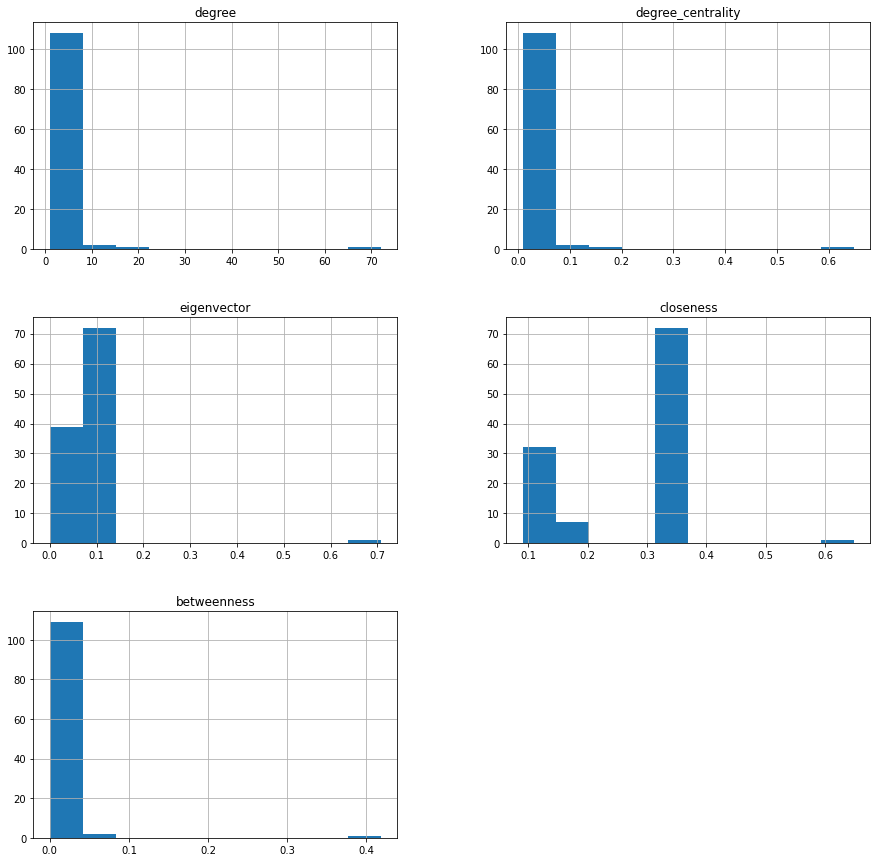

In [13]:
summaries.hist(bins = 10, figsize = (15, 15))
plt.show()